In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet , LinearRegression 
from sklearn.model_selection import RandomizedSearchCV , cross_validate , train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score , mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor

In [3]:
data = pd.read_csv("traffic_accidents_dict new.csv")
df = data.copy()
df.head()

,accidents,traffic_fine_amount,traffic_density,traffic_lights,pavement_quality,urban_area,average_speed,rain_intensity,vehicle_count,time_of_day,Variable,Description
0,20,4.37,2.30,753.00,0.77,1,321.59,1.19,290.86,160.43,accidents,"Number of recorded accidents, as a positive in..."
1,11,9.56,3.28,5.45,4.05,1,478.62,6.30,931.81,8.91,traffic_fine_amount,"Traffic fine amount, expressed in thousands of..."
2,19,7.59,2.10,6.70,345.00,0,364.48,2.86,830.09,5.57,traffic_density,"Traffic density index, scale from 0 (low) to 1..."
3,23,6.39,4.92,9.41,4.73,0,20.92,2.11,813.16,131.45,traffic_lights,Proportion of traffic lights in the area (0 to...
4,23,2.40,1.96,7.39,1.71,1,37.38,1.70,1.47,6.96,pavement_quality,"Pavement quality, scale from 0 (very poor) to ..."


In [4]:
def check_df(data,head=False):
    print("-------------------------- SHAPE --------------------------")
    print(data.shape)
    print("-------------------------- INFO --------------------------")
    print(data.info())
    print("-------------------------- ISNA --------------------------")
    print(data.isnull().sum().sort_values(ascending=False))    
    print("-------------------------- NUNIQUE --------------------------")
    print(data.nunique().sort_values())
    print("-------------------------- DUPLICATED --------------------------")
    print(data.duplicated().sum())
    print("-------------------------- DESCRIBE --------------------------")
    display(data.describe().T)
    if head:
        print("-------------------------- HEAD --------------------------")
        display(data.head())
        print("-------------------------- TAIL --------------------------")
        display(data.tail())

In [5]:
def col_types(data):
    cat_cols = [col for col in data.columns if data[col].dtypes=="O"]
    num_cols = [col for col in data.columns if data[col].dtypes!="O"]
    print(f"OBSERVISION : {data.shape[1]}")
    print(f"CAT COLS : {len(cat_cols)}")
    print(f"NUM COLS : {len(num_cols)}") 
    return cat_cols , num_cols

In [6]:
def box_plot(df,col):
    sns.boxplot(data=df,x=col,palette="inferno")
    plt.title(f"{col.upper()} boxplot")
    plt.tight_layout()
    plt.show()

In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [8]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
def cat_plot(df, col):
    plt.figure(figsize=(14,6))  
    order = df[col].value_counts().index 
    ax = sns.countplot(x=col, data=df, palette="viridis", order=order)
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{percentage:.2f}%', 
                ha="center", va="bottom", fontsize=10)
    plt.title(col.upper()) 
    plt.ylabel(col.upper())
    plt.xticks(rotation=45)
    plt.xlabel("COUNT")
    plt.tight_layout()
    plt.show()
    print("------------------------------------------------------------------------------------------------------------------", end="\n\n")

In [11]:
def hist_plot(data, col):    
    plt.figure(figsize=(10,6))
    sns.histplot(x=col,data=df,kde=True,bins=25,color="g")
    plt.title(col.upper())
    plt.ylabel("COUNT")
    plt.xlabel(col.upper())
    plt.tight_layout()
    plt.show()
    print("----------------------------------------------------------------------------------------",end="\n\n")

In [12]:
def base_models(X,y,scoring="neg_mean_squared_error"):
  print("Base Models")
  regressions = [('Ridge',Ridge(alpha=1)),
                 ('Lasso',Lasso(alpha=1)),
                 ('ElasticNet',ElasticNet(alpha=1,l1_ratio=0.5)),
                 ("Linear",LinearRegression()),
                 ("Decision Tree",DecisionTreeRegressor()),
                 ("Random Forest",RandomForestRegressor()),
                 ('Gradient Boosting', GradientBoostingRegressor()),                 
                 ("XGB",XGBRegressor(objective='reg:squarederror')),
                 ('KNN', KNeighborsRegressor()),
                 ('MLP', MLPRegressor()),
                 ('Bayesian Ridge', BayesianRidge()),
                 ("CatBoost",CatBoostRegressor(verbose=0))]
  for name,regression in regressions:
    cv_results = cross_validate(regression,X,y,cv=10,scoring=scoring)
    print(f"{scoring}: {round(cv_results['test_score'].mean(),4)} {name}")

In [13]:
def hyperparameter_optimization_randomized(X, y, cv=5, scoring="r2", n_iter=100):
    print("HYPERPARAMETER OPTIMIZATION WITH RANDOMIZEDSEARCH")
    best_models = {}

    
    regressors = [
        ('GradientBoosting', GradientBoostingRegressor(), gb_params),
        ('CatBoost', CatBoostRegressor(verbose=0), cat_params),        
        ('XGBoost', XGBRegressor(objective='reg:squarederror'), xgb_params)
    ]

    for name, regressor, params in regressors:
        print(f"----------------- {name} -----------------")

        
        cv_results = cross_validate(regressor, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

       
        rs_best = RandomizedSearchCV(
            regressor,
            params,
            cv=cv,
            n_jobs=-1,
            verbose=False,
            n_iter=n_iter,
            random_state=42
        ).fit(X, y)

        
        final_model = regressor.set_params(**rs_best.best_params_)

        
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {rs_best.best_params_}", end="\n\n")

        
        best_models[name] = final_model

    return best_models

In [14]:
def voting_regressor(best_models, X, y, cv=5):
    print("Voting Regressor")
    
    voting_reg = VotingRegressor(estimators=[
        ("XGB", best_models['XGBoost']),
        ("GradientBoosting", best_models['GradientBoosting']),        
        ("CatBoost",best_models["CatBoost"])
    ]).fit(X, y)

   
    cv_results = cross_validate(voting_reg, X, y, cv=cv, scoring=["neg_mean_squared_error", "r2"])
    
    print(f"Neg MSE: {-cv_results['test_neg_mean_squared_error'].mean()}")  
    print(f"R^2: {cv_results['test_r2'].mean()}")

    return voting_reg

In [15]:
def plot_importance_ensemble(voting_reg, features):
    num=len(features)
    feature_imp_df = pd.DataFrame(0, index=features.columns, columns=["Value"])
    
    
    for model in voting_reg.estimators_:
        if hasattr(model, 'feature_importances_'):
            
            feature_imp_df["Value"] += model.feature_importances_ /100

    
    feature_imp_df["Feature"] = features.columns
    feature_imp_df = feature_imp_df.sort_values(by="Value", ascending=False)
    
    
    plt.figure(figsize=(12, 7))
    sns.set(font_scale=1)
    ax = sns.barplot(x="Value", y="Feature", data=feature_imp_df[0:num])
    
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.4f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=8)
    
    plt.title("Feature Importance - Voting Regressor")
    plt.tight_layout()
    plt.show()

In [16]:
check_df(df,True)

-------------------------- SHAPE --------------------------
(8756, 12)
-------------------------- INFO --------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   accidents            8756 non-null   int64  
 1   traffic_fine_amount  8756 non-null   float64
 2   traffic_density      8756 non-null   float64
 3   traffic_lights       8756 non-null   float64
 4   pavement_quality     8756 non-null   float64
 5   urban_area           8756 non-null   int64  
 6   average_speed        8756 non-null   float64
 7   rain_intensity       8756 non-null   float64
 8   vehicle_count        8756 non-null   float64
 9   time_of_day          8756 non-null   float64
 10  Variable             8756 non-null   object 
 11  Description          8756 non-null   object 
dtypes: float64(8), int64(2), object(2)
memory usage: 821.0+ KB

,count,mean,std,min,25%,50%,75%,max
accidents,8756.00,20.63,5.23,5.00,17.00,21.00,24.00,35.00
traffic_fine_amount,8756.00,5.45,2.60,1.00,3.20,5.43,7.68,10.00
traffic_density,8756.00,14.25,75.97,0.24,3.32,5.56,7.89,996.00
traffic_lights,8756.00,93.29,224.17,0.00,3.78,6.50,9.23,999.00
pavement_quality,8756.00,22.44,112.19,0.00,2.10,3.28,4.43,994.00
urban_area,8756.00,0.69,0.46,0.00,0.00,1.00,1.00,1.00
average_speed,8756.00,214.64,168.71,0.97,12.51,223.13,360.94,932.00
rain_intensity,8756.00,33.86,140.05,0.00,1.67,2.36,3.70,999.00
vehicle_count,8756.00,453.23,313.88,1.03,169.46,453.98,729.15,999.62
time_of_day,8756.00,83.65,97.82,0.12,6.51,12.18,174.78,999.00


-------------------------- HEAD --------------------------


,accidents,traffic_fine_amount,traffic_density,traffic_lights,pavement_quality,urban_area,average_speed,rain_intensity,vehicle_count,time_of_day,Variable,Description
0,20,4.37,2.30,753.00,0.77,1,321.59,1.19,290.86,160.43,accidents,"Number of recorded accidents, as a positive in..."
1,11,9.56,3.28,5.45,4.05,1,478.62,6.30,931.81,8.91,traffic_fine_amount,"Traffic fine amount, expressed in thousands of..."
2,19,7.59,2.10,6.70,345.00,0,364.48,2.86,830.09,5.57,traffic_density,"Traffic density index, scale from 0 (low) to 1..."
3,23,6.39,4.92,9.41,4.73,0,20.92,2.11,813.16,131.45,traffic_lights,Proportion of traffic lights in the area (0 to...
4,23,2.40,1.96,7.39,1.71,1,37.38,1.70,1.47,6.96,pavement_quality,"Pavement quality, scale from 0 (very poor) to ..."


-------------------------- TAIL --------------------------


,accidents,traffic_fine_amount,traffic_density,traffic_lights,pavement_quality,urban_area,average_speed,rain_intensity,vehicle_count,time_of_day,Variable,Description
8751,27,2.77,6.94,6.60,3.36,1,302.00,1.98,258.92,11.15,0,0
8752,18,3.26,1.73,549.00,2.85,1,6.30,8.27,296.40,17.04,0,0
8753,31,2.56,8.53,2.78,3.28,1,479.93,2.82,458.21,192.77,0,0
8754,10,9.62,1.40,2.72,5.78,1,280.78,6.40,147.66,3.64,0,0
8755,12,8.69,4.20,5.39,2.38,0,234.63,1.12,483.98,1.08,0,0


In [17]:
cat_cols , num_cols = col_types(df)

OBSERVISION : 12
CAT COLS : 2
NUM COLS : 10


In [18]:
df[cat_cols].head()

,Variable,Description
0,accidents,"Number of recorded accidents, as a positive in..."
1,traffic_fine_amount,"Traffic fine amount, expressed in thousands of..."
2,traffic_density,"Traffic density index, scale from 0 (low) to 1..."
3,traffic_lights,Proportion of traffic lights in the area (0 to...
4,pavement_quality,"Pavement quality, scale from 0 (very poor) to ..."


In [19]:
df[num_cols].head()

,accidents,traffic_fine_amount,traffic_density,traffic_lights,pavement_quality,urban_area,average_speed,rain_intensity,vehicle_count,time_of_day
0,20,4.37,2.30,753.00,0.77,1,321.59,1.19,290.86,160.43
1,11,9.56,3.28,5.45,4.05,1,478.62,6.30,931.81,8.91
2,19,7.59,2.10,6.70,345.00,0,364.48,2.86,830.09,5.57
3,23,6.39,4.92,9.41,4.73,0,20.92,2.11,813.16,131.45
4,23,2.40,1.96,7.39,1.71,1,37.38,1.70,1.47,6.96


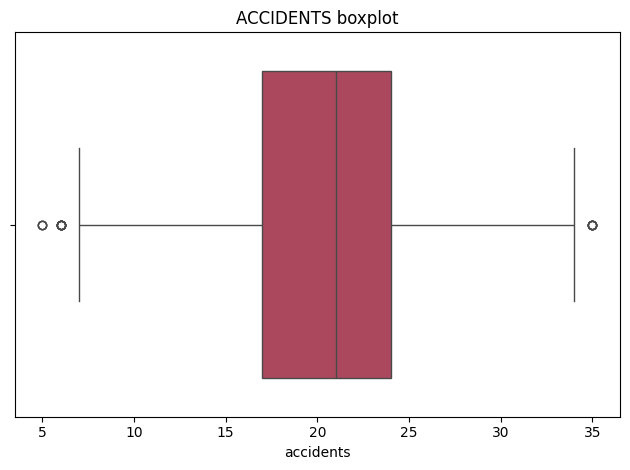

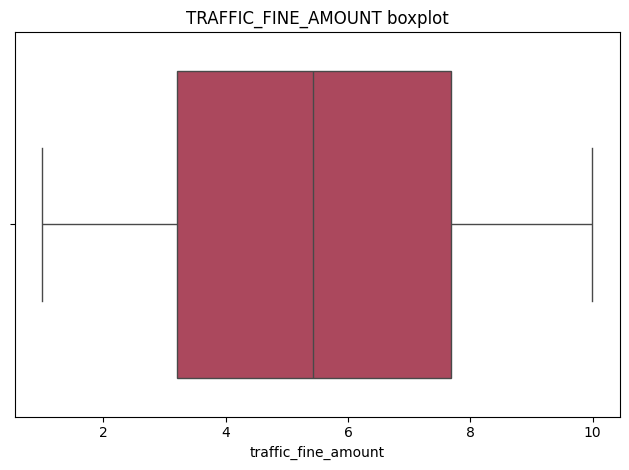

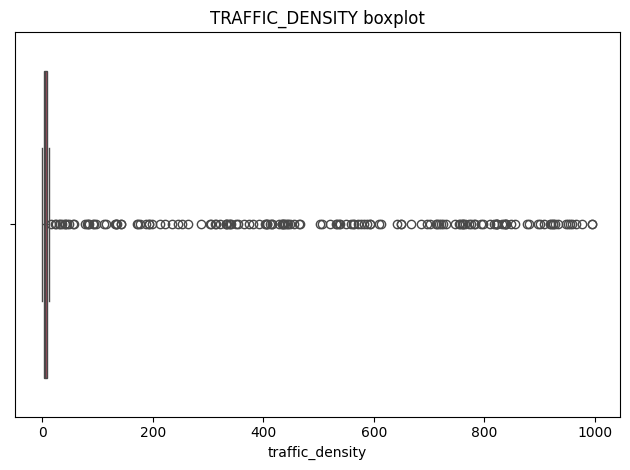

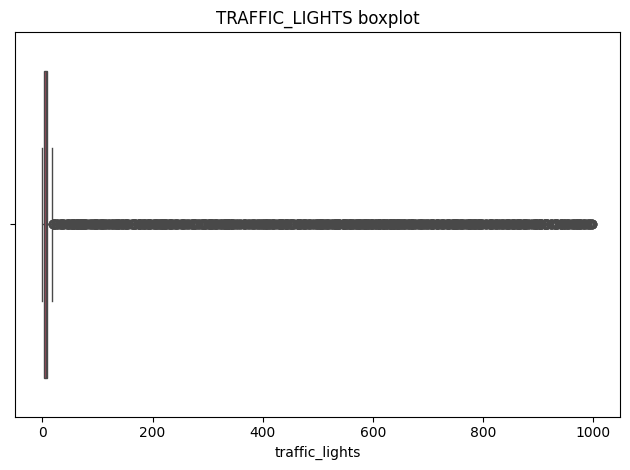

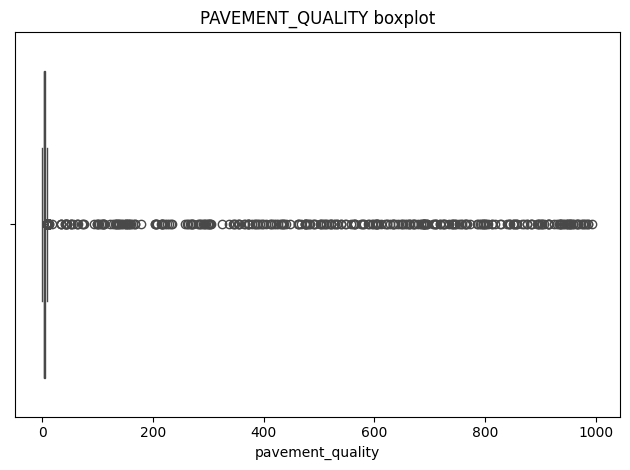

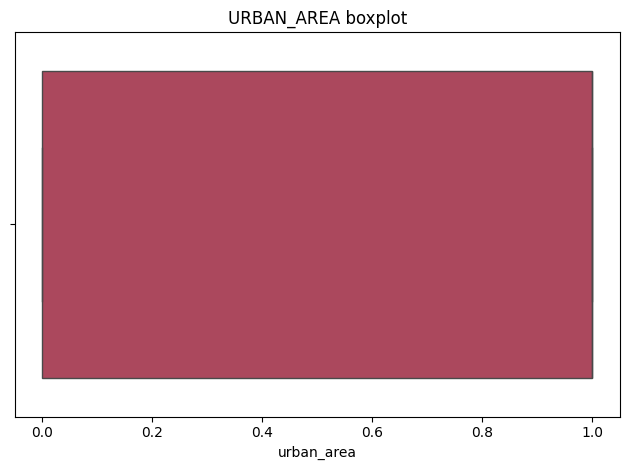

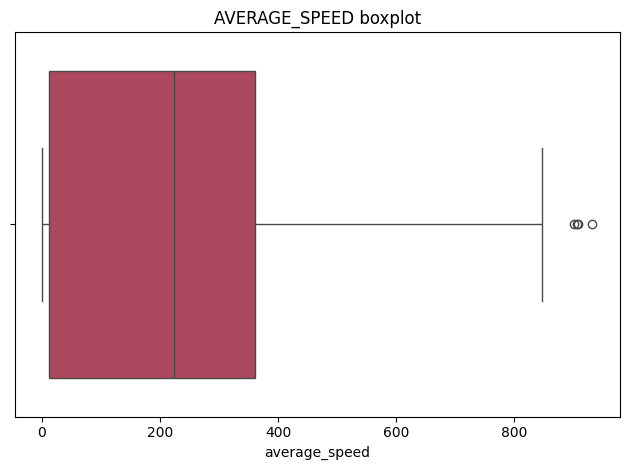

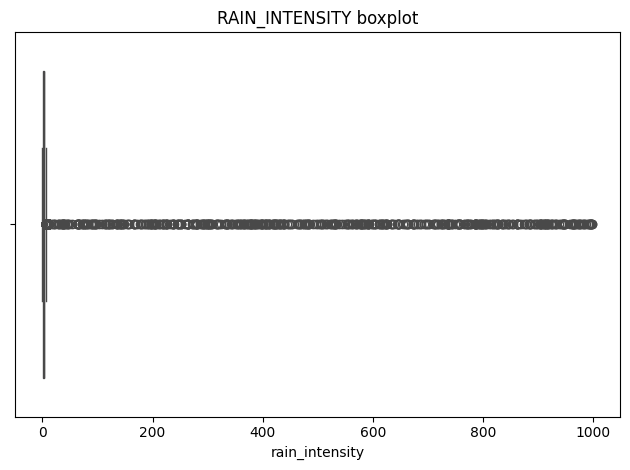

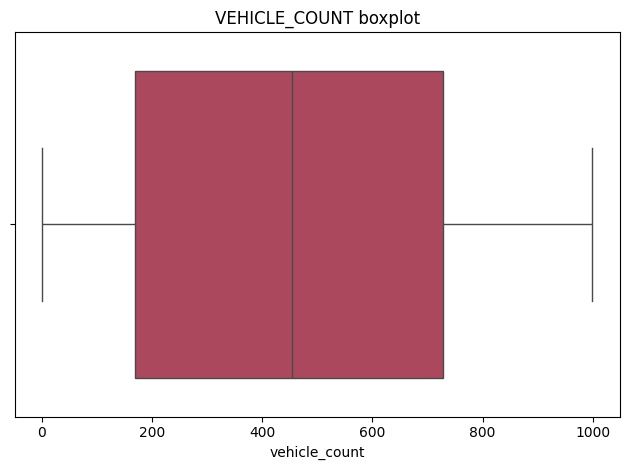

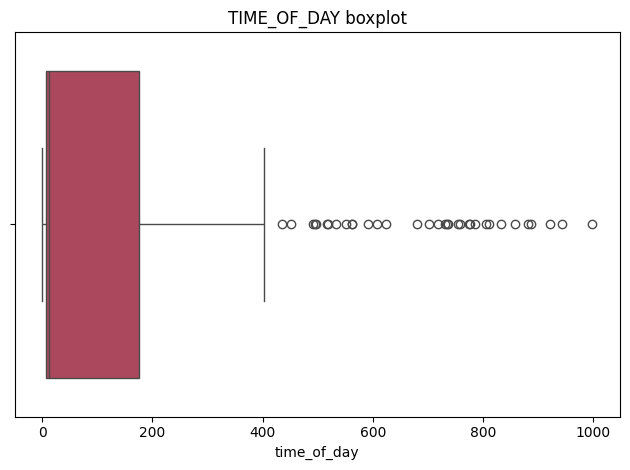

In [20]:
for col in num_cols:
    box_plot(df,col)

In [21]:
for col in num_cols:
    print(col.upper()," ",check_outlier(df,col))

ACCIDENTS   True
TRAFFIC_FINE_AMOUNT   False
TRAFFIC_DENSITY   True
TRAFFIC_LIGHTS   True
PAVEMENT_QUALITY   True
URBAN_AREA   False
AVERAGE_SPEED   True
RAIN_INTENSITY   True
VEHICLE_COUNT   False
TIME_OF_DAY   True


In [22]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [23]:
for col in num_cols:
    print(col.upper()," ",check_outlier(df,col))

ACCIDENTS   False
TRAFFIC_FINE_AMOUNT   False
TRAFFIC_DENSITY   False
TRAFFIC_LIGHTS   False
PAVEMENT_QUALITY   False
URBAN_AREA   False
AVERAGE_SPEED   False
RAIN_INTENSITY   False
VEHICLE_COUNT   False
TIME_OF_DAY   False


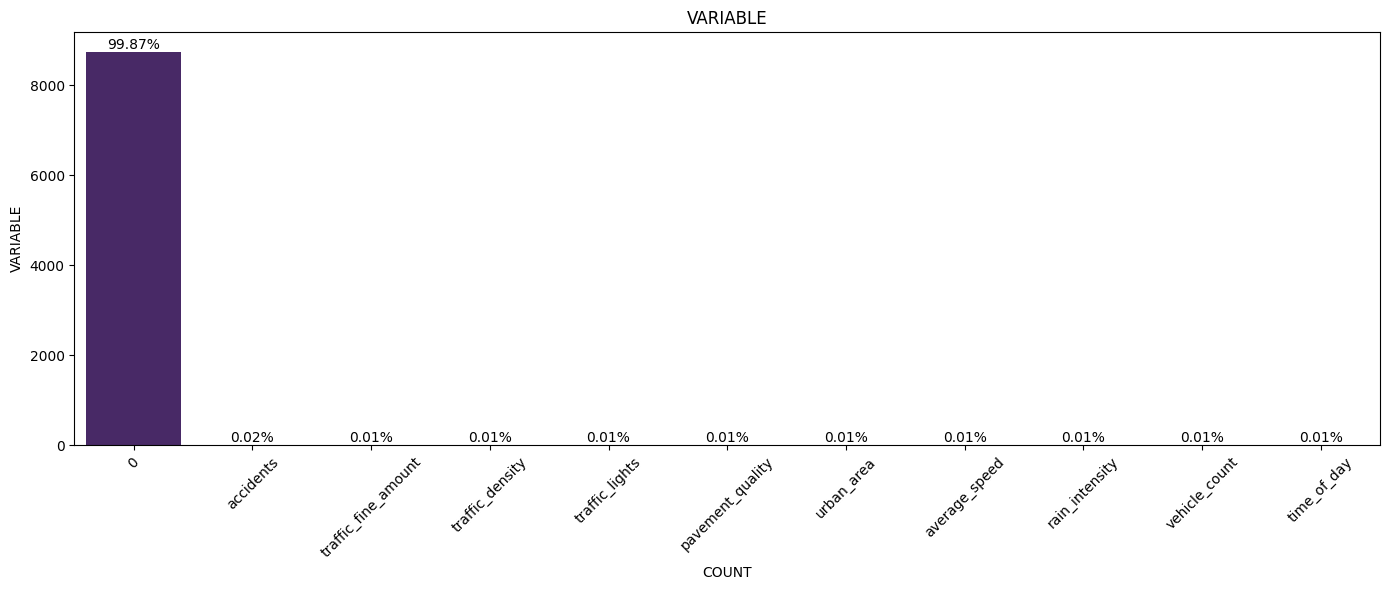

------------------------------------------------------------------------------------------------------------------



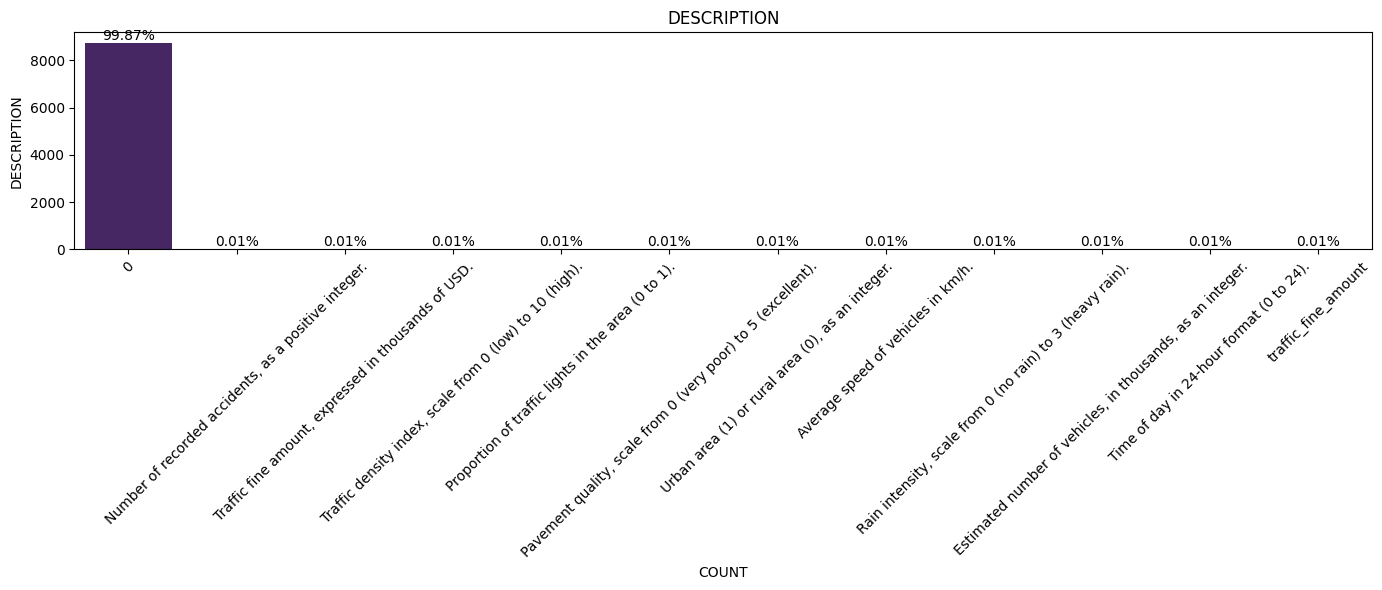

------------------------------------------------------------------------------------------------------------------



In [24]:
for col in cat_cols:
    cat_plot(df,col)

In [25]:
df = df[df["Variable"]=="0"]

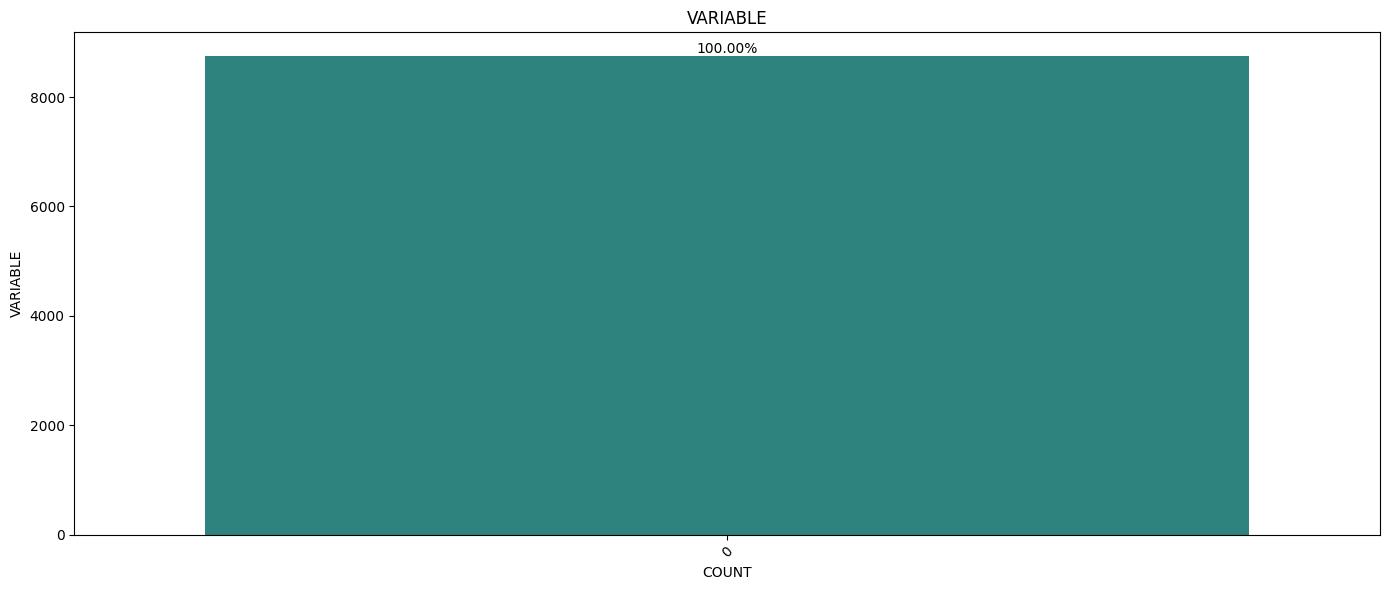

------------------------------------------------------------------------------------------------------------------



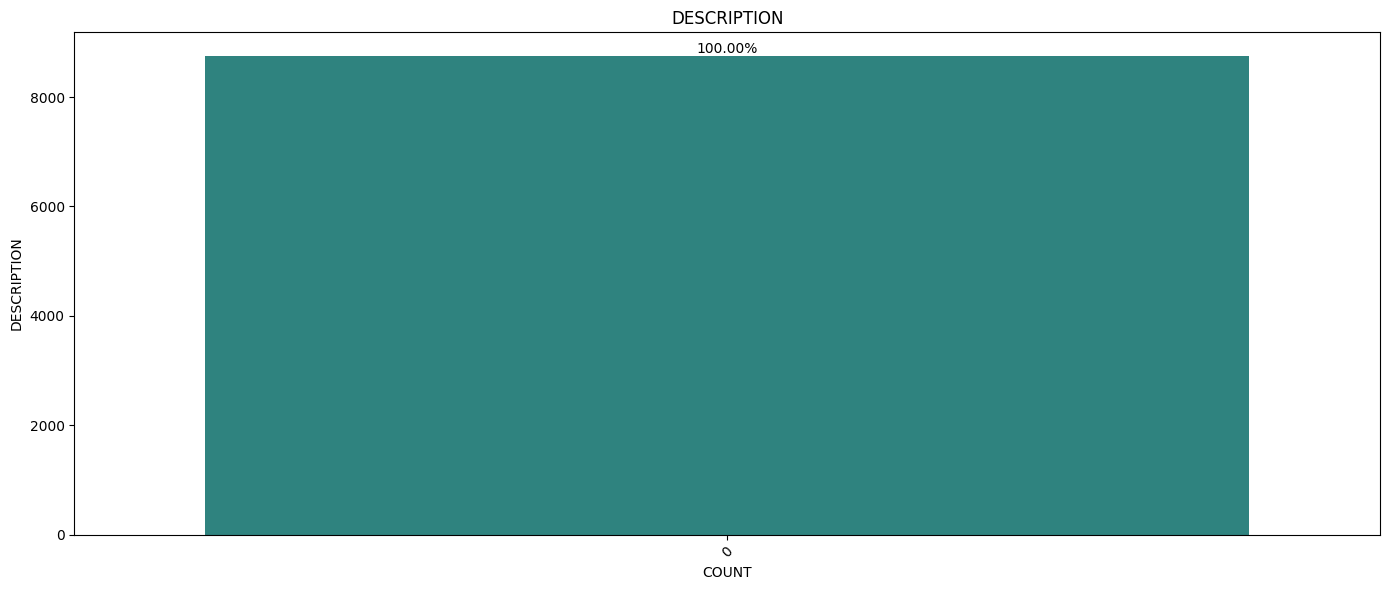

------------------------------------------------------------------------------------------------------------------



In [26]:
for col in cat_cols:
    cat_plot(df,col)

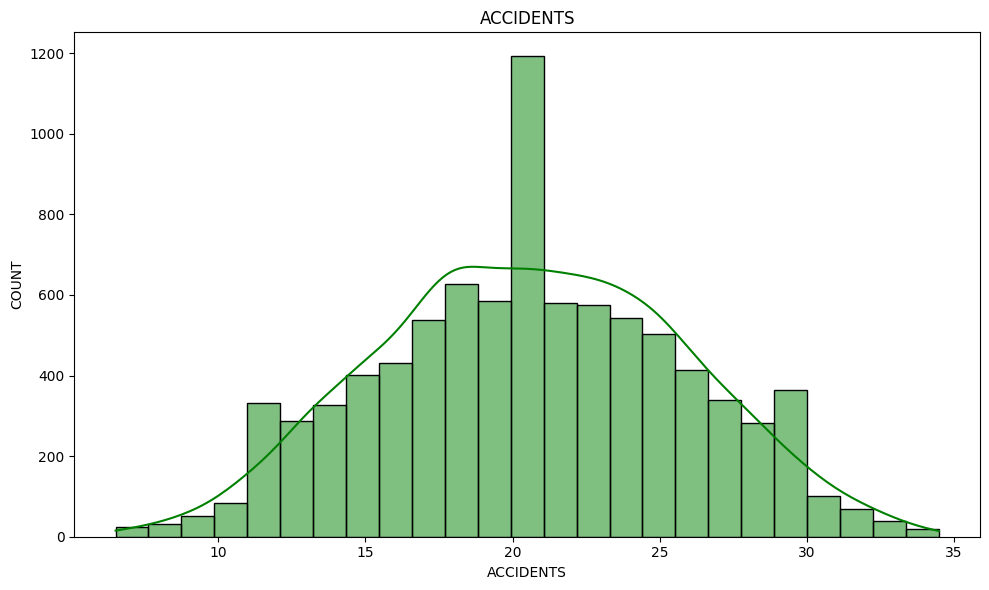

----------------------------------------------------------------------------------------



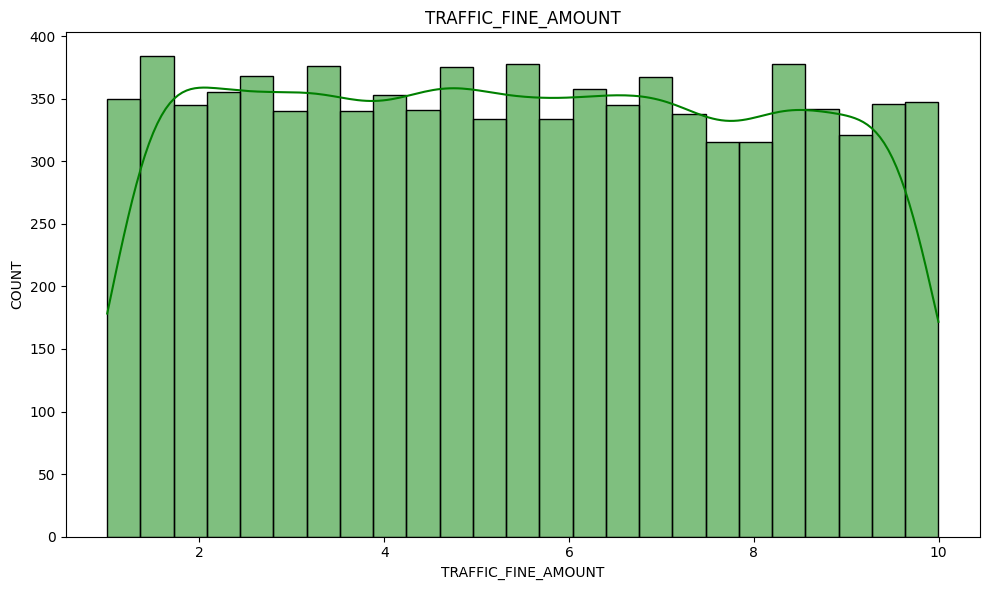

----------------------------------------------------------------------------------------



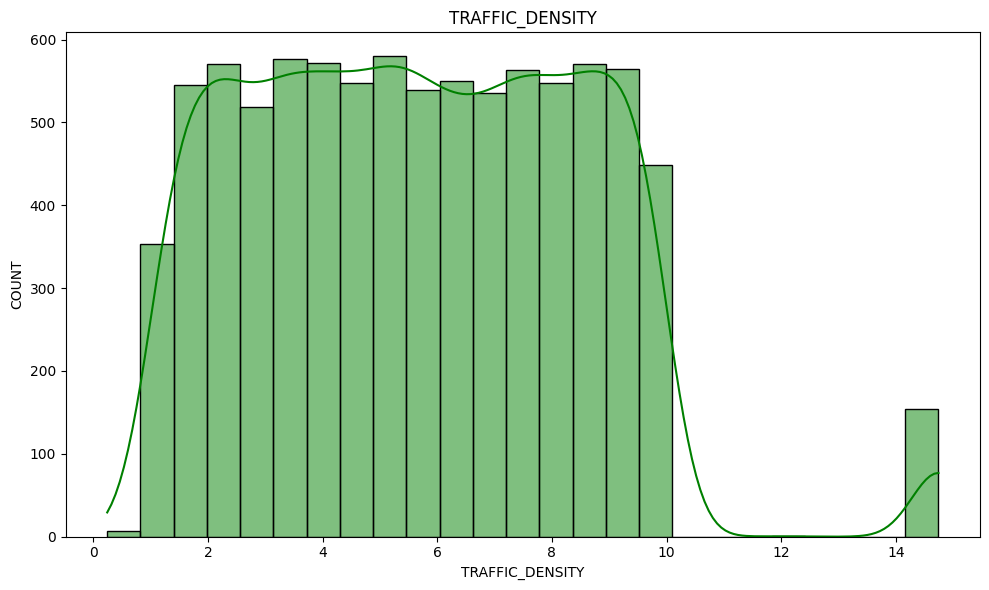

----------------------------------------------------------------------------------------



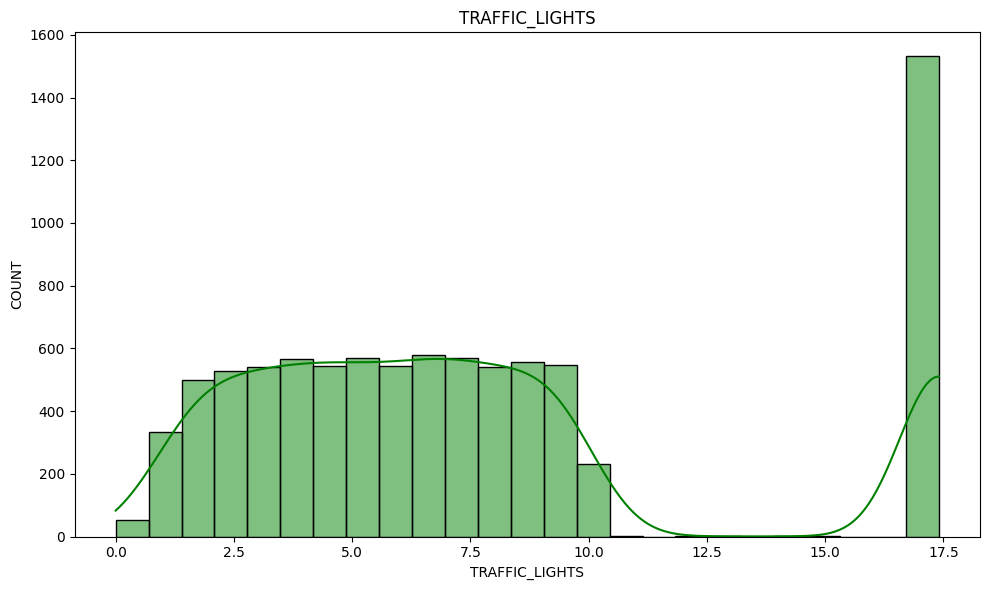

----------------------------------------------------------------------------------------



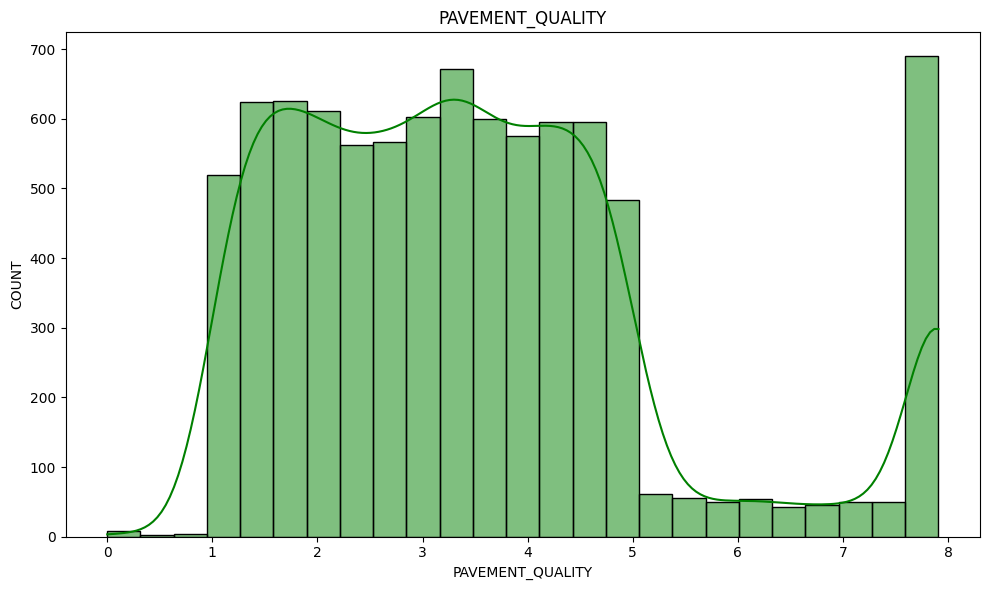

----------------------------------------------------------------------------------------



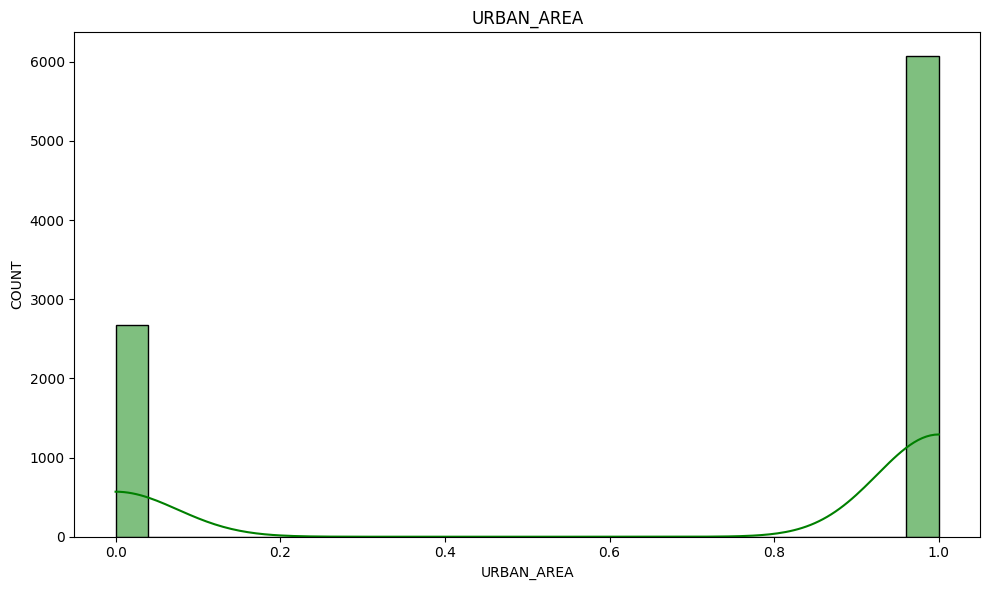

----------------------------------------------------------------------------------------



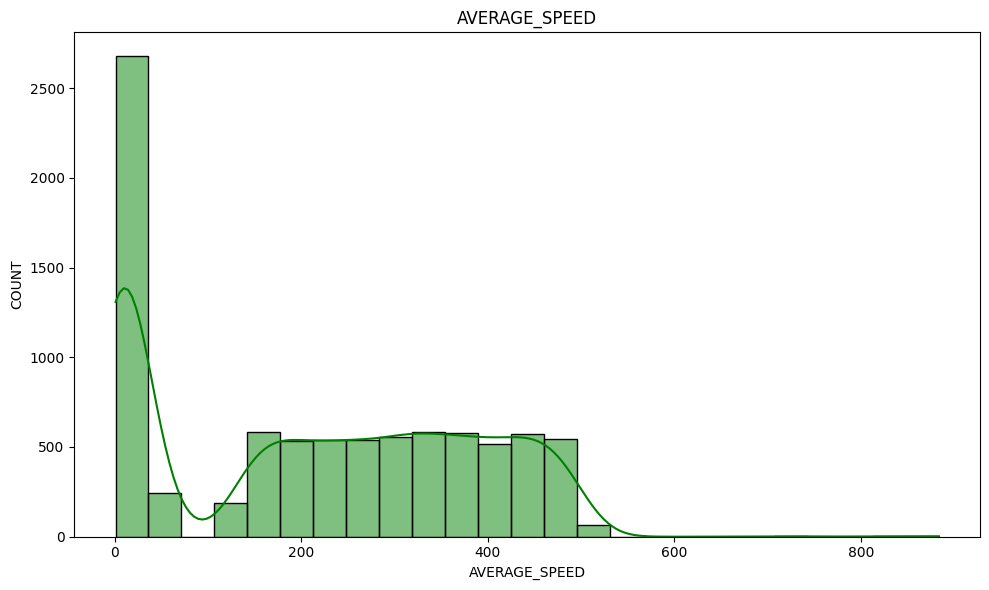

----------------------------------------------------------------------------------------



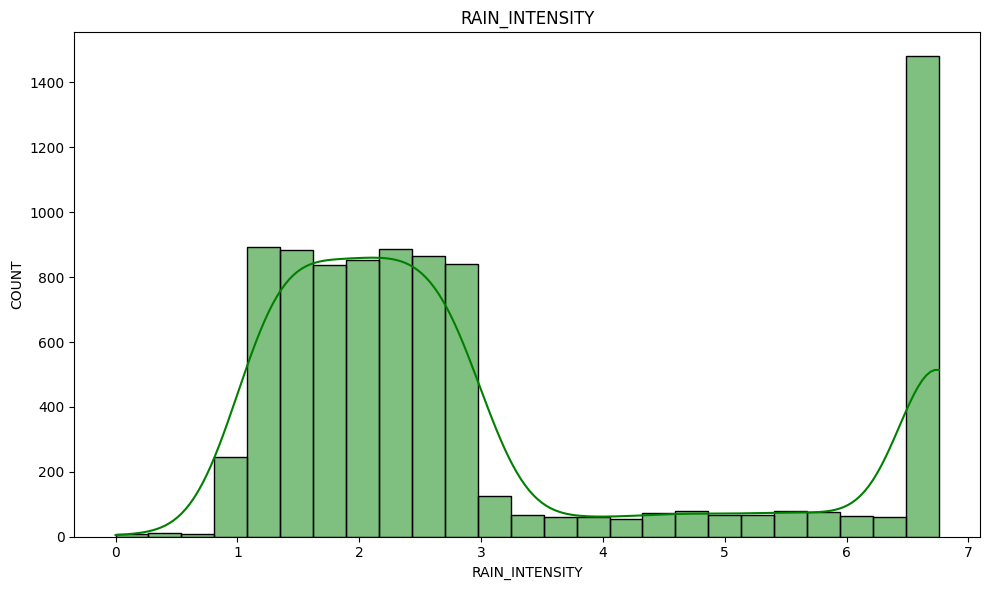

----------------------------------------------------------------------------------------



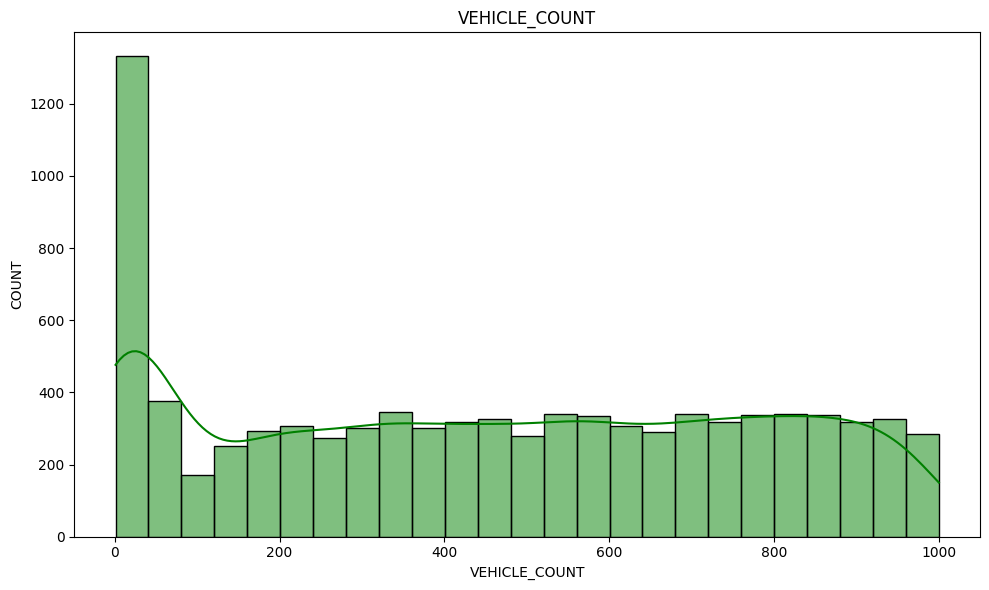

----------------------------------------------------------------------------------------



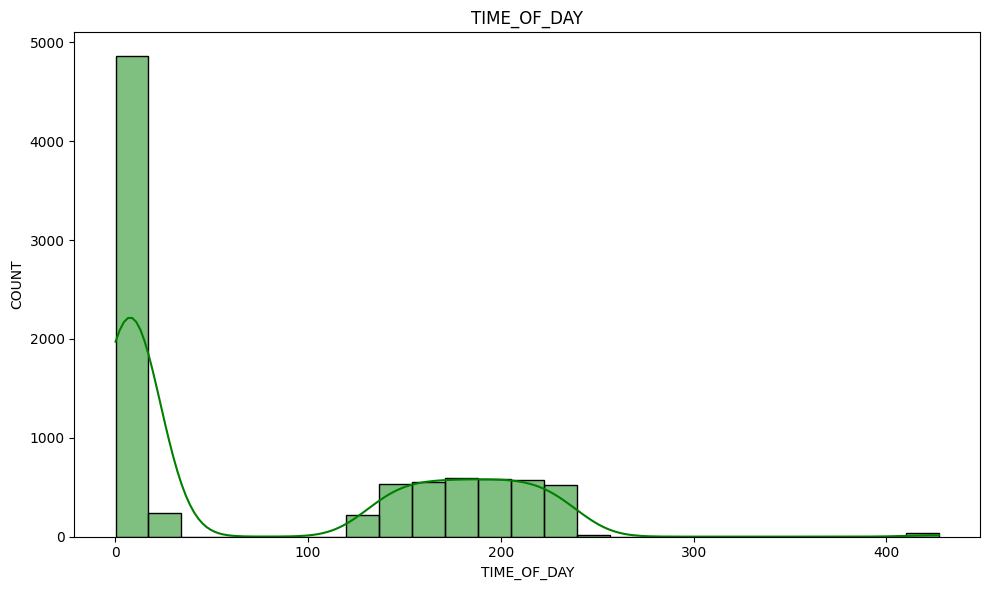

----------------------------------------------------------------------------------------



In [27]:
for col in num_cols:
    hist_plot(df,col)

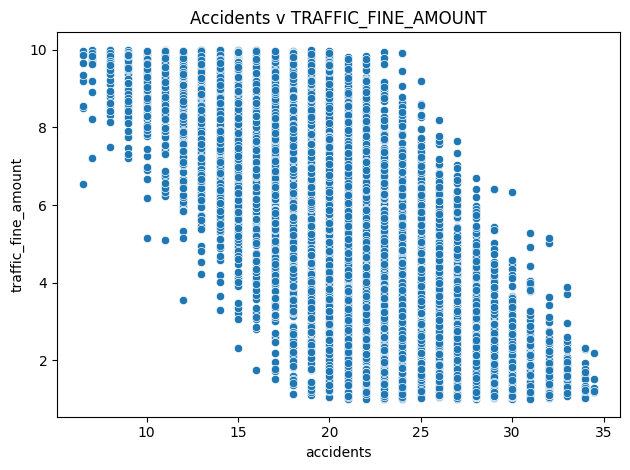

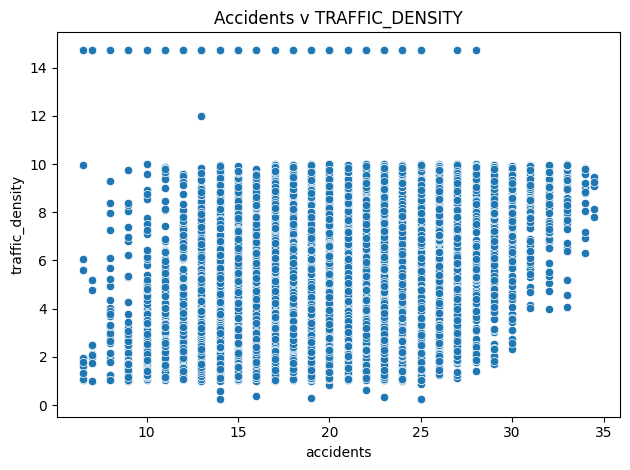

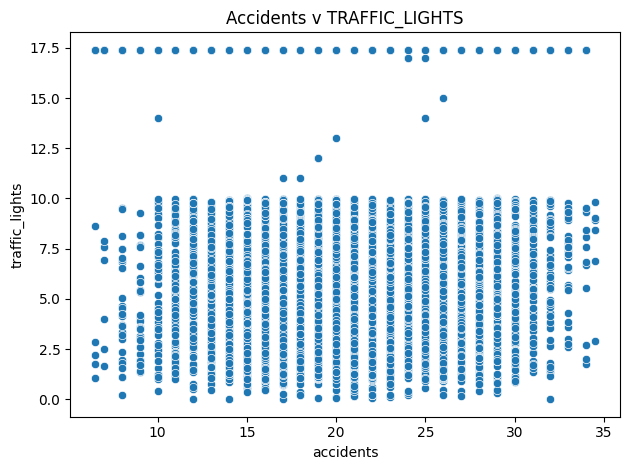

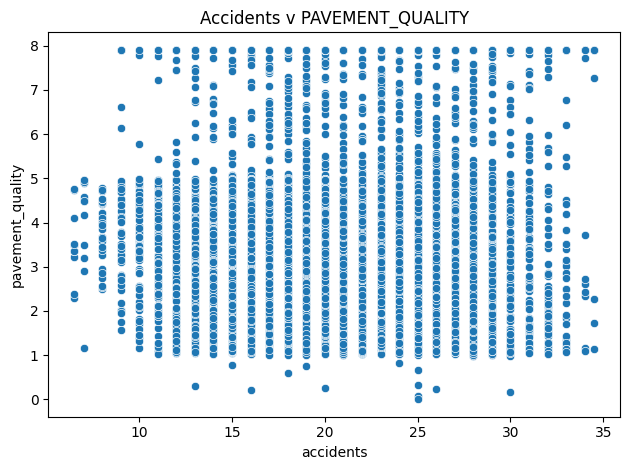

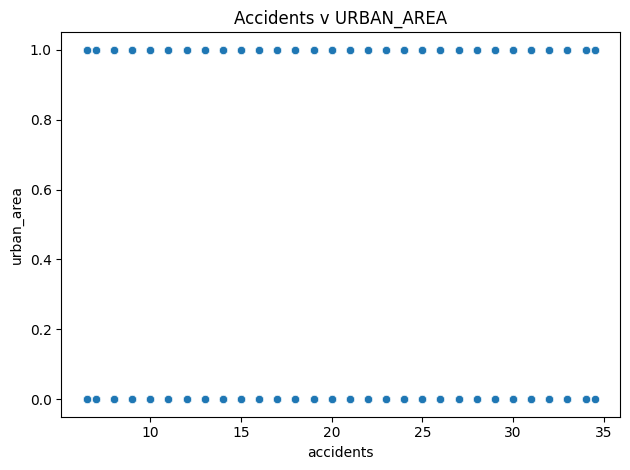

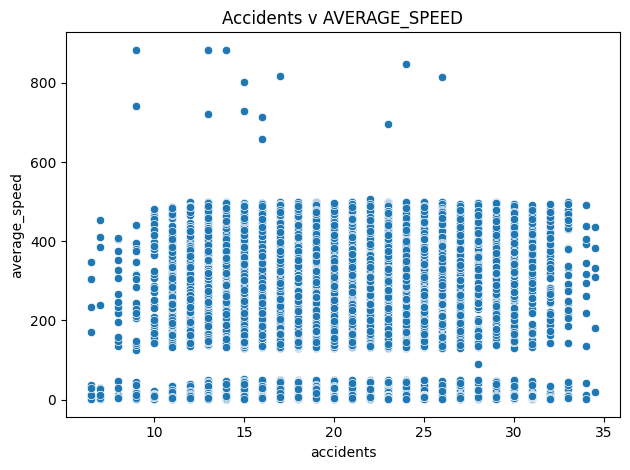

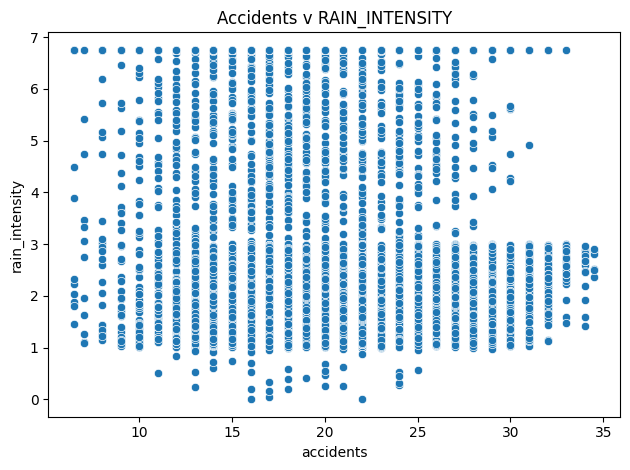

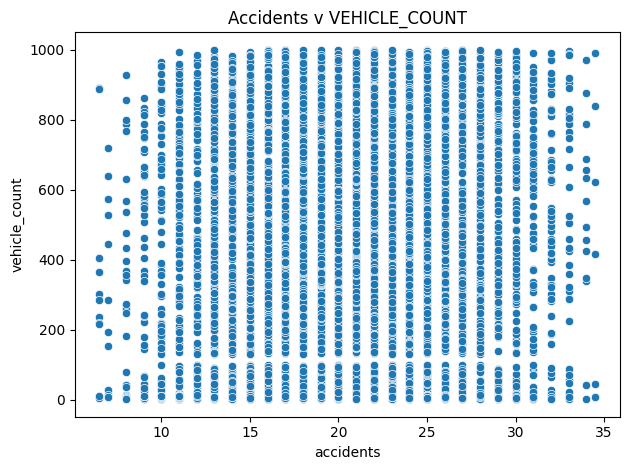

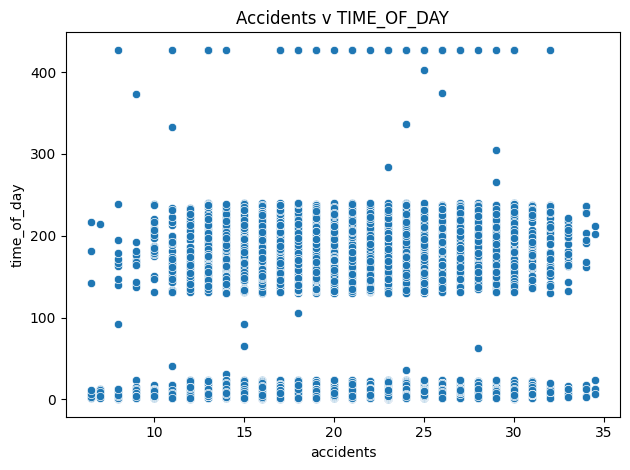

In [28]:
nums = [col for col in num_cols if col not in "accidents"]
for col in nums:
    sns.scatterplot(data=df, x="accidents", y=col)
    plt.title(f"Accidents v {col.upper()}")
    plt.tight_layout()
    plt.show()

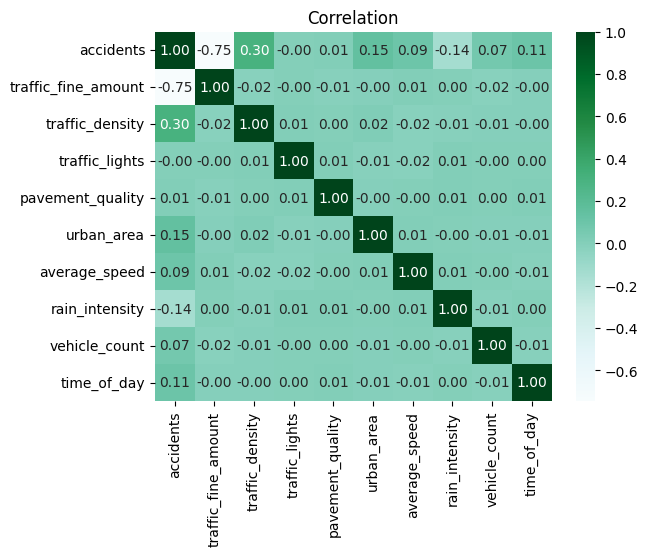

In [29]:
sns.heatmap(df[num_cols].corr(),annot=True,fmt=".2f",cmap="BuGn")
plt.title("Correlation",fontsize=12)
plt.show()

In [30]:
X = df.drop(["accidents","Variable","Description"],axis=1)
y = df["accidents"]

In [31]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [32]:
scaler = MinMaxScaler()

In [33]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [34]:
print(f"X Train Shape : {X_train.shape}\nX Test Shape : {X_test.shape}\nY Train Shape : {y_train.shape}\nY Test Shape : {y_test.shape}")

X Train Shape : (6996, 9)
X Test Shape : (1749, 9)
Y Train Shape : (6996,)
Y Test Shape : (1749,)


In [35]:
base_models(X_train,y_train,"r2")

Base Models
r2: 0.6958 Ridge
r2: 0.116 Lasso
r2: 0.0833 ElasticNet
r2: 0.6958 Linear
r2: 0.5707 Decision Tree
r2: 0.801 Random Forest
r2: 0.8352 Gradient Boosting
r2: 0.808 XGB
r2: 0.7134 KNN
r2: 0.7973 MLP
r2: 0.6958 Bayesian Ridge
r2: 0.8466 CatBoost


In [36]:
cat_params = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 5, 7, 10]
}

gb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

In [37]:
best_models = hyperparameter_optimization_randomized(X_train,y_train,n_iter=10)

HYPERPARAMETER OPTIMIZATION WITH RANDOMIZEDSEARCH
----------------- GradientBoosting -----------------
r2 (Before): 0.8361
r2 (After): 0.8389
GradientBoosting best params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}

----------------- CatBoost -----------------
r2 (Before): 0.8457
r2 (After): 0.8488
CatBoost best params: {'learning_rate': 0.05, 'iterations': 300, 'depth': 5}

----------------- XGBoost -----------------
r2 (Before): 0.8068
r2 (After): 0.8309
XGBoost best params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}



In [38]:
voting_reg = voting_regressor(best_models,X_train,y_train)

Voting Regressor
Neg MSE: 4.272705632654722
R^2: 0.8442041169906338


In [39]:
predict = voting_reg.predict(X_test)

In [40]:
print(f"R2 Score: {r2_score(y_test, predict):.4f}")
print(f"MSE: {mean_squared_error(y_test, predict):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predict)):.4f}")

R2 Score: 0.8453
MSE: 4.1274
RMSE: 2.0316


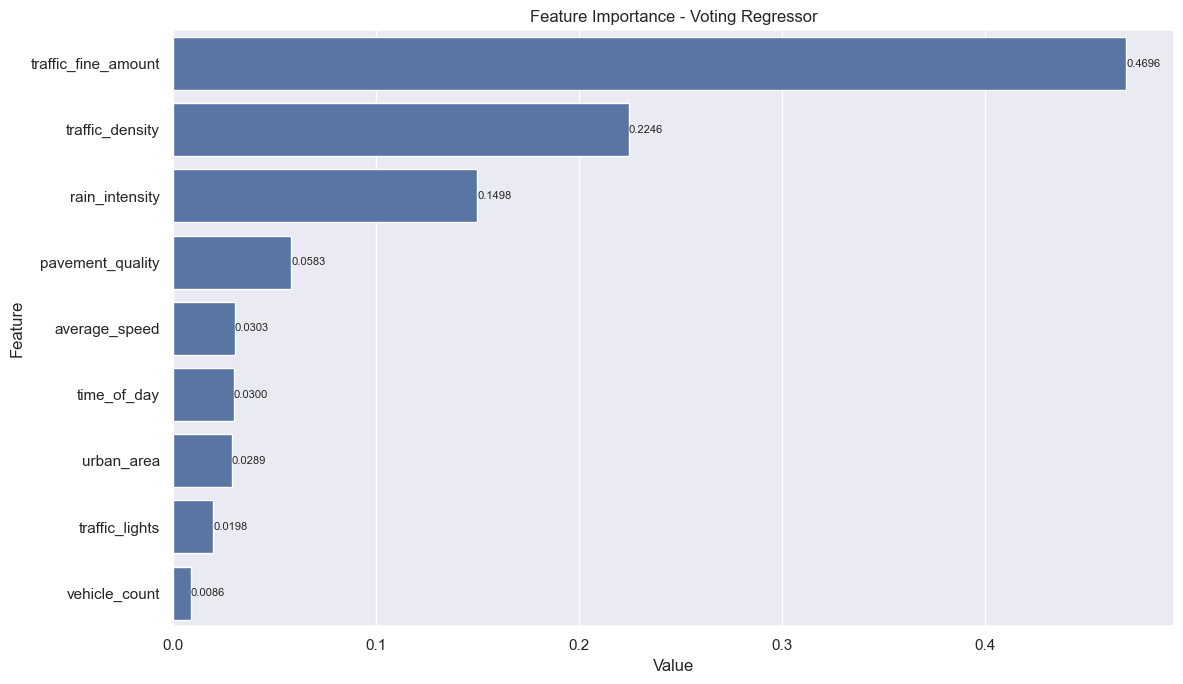

In [41]:
plot_importance_ensemble(voting_reg,X)